* cluster head
* client_ratio
* non-IID data
* DBSCAN
* batch size
* plot

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import unique
from numpy import where
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import Sequential
from matplotlib import pyplot as plt
plt.rcParams.update({'font.family':'serif'})
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
import random
from itertools import accumulate

In [ ]:
# Global variablles
TOT_CLIENTS = 100
learning_rate_list = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
NUM_ROUNDS = 10
CLIENT_RATIO = 0.3
DATA_DIV = 6000
NUM_CLIENTS = int(TOT_CLIENTS * CLIENT_RATIO)
div_list = [np.random.randint(3000,6000) for i in range(NUM_CLIENTS)]
origin_list = [np.random.randint(0,60000-6000) for i in range(NUM_CLIENTS)]

In [ ]:
div_list

[4794,
 3137,
 3572,
 3056,
 3391,
 3739,
 4398,
 5397,
 3345,
 5428,
 3048,
 5419,
 5420,
 4330,
 3958,
 4047,
 5289,
 4300,
 4283,
 3209,
 4611,
 3615,
 3009,
 3367,
 3914,
 5253,
 5894,
 5198,
 5897,
 4742]

In [ ]:
origin_list

[36308,
 31478,
 4675,
 43813,
 22952,
 21317,
 8091,
 39339,
 20394,
 6151,
 39182,
 11891,
 22790,
 14073,
 51668,
 50561,
 50206,
 43213,
 11,
 29651,
 22955,
 20325,
 15303,
 51567,
 16621,
 47746,
 32993,
 10069,
 42597,
 14686]

# Data Loading and Preprocessing

In [ ]:
#loading data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)

#reshape
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalixation
X_train /= 255
X_test /= 255

# One Hot encoding
ohe = OneHotEncoder(sparse=False)
y_train=ohe.fit_transform(y_train.reshape(-1, 1))
y_test=ohe.transform(y_test.reshape(-1, 1))

(60000, 28, 28)


In [ ]:
client_train_x = []
client_train_y = []

for i in range(NUM_CLIENTS):
  print([origin_list[i], origin_list[i]+div_list[i]])
  client_train_x.append(X_train[origin_list[i]:origin_list[i]+div_list[i]])
  client_train_y.append(y_train[origin_list[i]:origin_list[i]+div_list[i]])

[36308, 41102]
[31478, 34615]
[4675, 8247]
[43813, 46869]
[22952, 26343]
[21317, 25056]
[8091, 12489]
[39339, 44736]
[20394, 23739]
[6151, 11579]
[39182, 42230]
[11891, 17310]
[22790, 28210]
[14073, 18403]
[51668, 55626]
[50561, 54608]
[50206, 55495]
[43213, 47513]
[11, 4294]
[29651, 32860]
[22955, 27566]
[20325, 23940]
[15303, 18312]
[51567, 54934]
[16621, 20535]
[47746, 52999]
[32993, 38887]
[10069, 15267]
[42597, 48494]
[14686, 19428]


In [ ]:
[i.shape for i in client_train_x]

[(4794, 28, 28, 1),
 (3137, 28, 28, 1),
 (3572, 28, 28, 1),
 (3056, 28, 28, 1),
 (3391, 28, 28, 1),
 (3739, 28, 28, 1),
 (4398, 28, 28, 1),
 (5397, 28, 28, 1),
 (3345, 28, 28, 1),
 (5428, 28, 28, 1),
 (3048, 28, 28, 1),
 (5419, 28, 28, 1),
 (5420, 28, 28, 1),
 (4330, 28, 28, 1),
 (3958, 28, 28, 1),
 (4047, 28, 28, 1),
 (5289, 28, 28, 1),
 (4300, 28, 28, 1),
 (4283, 28, 28, 1),
 (3209, 28, 28, 1),
 (4611, 28, 28, 1),
 (3615, 28, 28, 1),
 (3009, 28, 28, 1),
 (3367, 28, 28, 1),
 (3914, 28, 28, 1),
 (5253, 28, 28, 1),
 (5894, 28, 28, 1),
 (5198, 28, 28, 1),
 (5897, 28, 28, 1),
 (4742, 28, 28, 1)]

In [ ]:
for num in range(10):
  print(div_list[num]*num, div_list[num]*(num+1))

0 4794
3137 6274
7144 10716
9168 12224
13564 16955
18695 22434
26388 30786
37779 43176
26760 30105
48852 54280


# Model Function

In [ ]:
def create_server_model():

  model=Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), input_shape = (28,28,1)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

# Model Cloner

In [ ]:
def model_cloner(model, learning_rate, optimizer):
    new_model = tf.keras.models.clone_model(model)
    new_model.set_weights(model.get_weights())
    if optimizer=='adam':
        new_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return new_model

# Initial Training

In [ ]:
def train_client_initial(num, model, lr_list):
  models = []
  losses = []

  for i in range(len(lr_list)):
    models.append(model_cloner(model, lr_list[i], 'adam'))
    hist = models[i].fit(client_train_x[num], client_train_y[num], epochs=1, batch_size=32, validation_data=(X_test, y_test))
    losses.append(round(hist.history['val_loss'][0], 4))

  ind = losses.index(min(losses))

  return models[ind], lr_list[ind], losses[ind]

In [ ]:
server_model = create_server_model()
server_model.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
server_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_init = []
losses = []
data = []
client_models = []
#start
for j in range(NUM_CLIENTS):
  print("----------------CLIENT " + str(j) +"-------------------------")

  lr_list = np.random.choice(learning_rate_list, 3, replace=False)
  data.append(train_client_initial(j, server_model, lr_list))

  client_models.append(data[j][0])
  lr_init.append(data[j][1])
  losses.append(data[j][2])

#aggregation
sum=[i*0 for i in client_models[0].get_weights()]
for i in range(NUM_CLIENTS):
  sum = [i+j for i, j in zip(client_models[i].get_weights(), sum)]
server_model.set_weights([i/NUM_CLIENTS for i in sum])

----------------CLIENT 0-------------------------
150/150 [==============================] - 3s 14ms/step - loss: 2.2921 - accuracy: 0.1585 - val_loss: 2.2836 - val_accuracy: 0.1850
----------------CLIENT 1-------------------------
99/99 [==============================] - 2s 15ms/step - loss: 2.2498 - accuracy: 0.3038 - val_loss: 2.1903 - val_accuracy: 0.4336
----------------CLIENT 2-------------------------
112/112 [==============================] - 2s 18ms/step - loss: 0.6213 - accuracy: 0.8219 - val_loss: 0.3420 - val_accuracy: 0.8945
----------------CLIENT 3-------------------------
96/96 [==============================] - 2s 16ms/step - loss: 2.2921 - accuracy: 0.1688 - val_loss: 2.2896 - val_accuracy: 0.1640
----------------CLIENT 4-------------------------
106/106 [==============================] - 2s 19ms/step - loss: 0.4955 - accuracy: 0.8464 - val_loss: 0.3304 - val_accuracy: 0.8995
----------------CLIENT 5-------------------------
117/117 [==============================] - 2

In [ ]:
server_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.4568 - accuracy: 0.9178


[0.456783652305603, 0.9178000092506409]

# Clustering

In [ ]:
from sklearn.cluster import DBSCAN

#lr_init = [0.01, 0.1, 0.00001, 0.001, 0.001, 0.0001, 0.1, 0.001, 0.00001, 0.000001]
lr_init1 = np.reshape(lr_init, (-1,1))
#print(lr_init)

model = DBSCAN(eps=0.0001, min_samples=2)
yhat = model.fit_predict(lr_init1)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
print(yhat)

[0 1 1 0 0 0 2 2 0 1 1 0 0 0 0 2 1 1 1 1 0 1 0 0 0 1 0 0 0 1]


# Genetic Mutation

In [ ]:
def mutate(lr):

    num = random.randint(-1,1)
    lr += (lr/10)*num

    return lr

# Genetic Mating

In [ ]:
def crossover(lrs):
  new_lrs = []

  new_lrs.append(lrs[0])
  if(len(lrs) >1):
    new_lrs.append(lrs[1])

  if(len(lrs) > 2):
    for i in range(2, len(lrs)):
      parentA = random.randint(0, len(lrs)-1)
      parentB = random.randint(0, len(lrs)-1)

      new_lrs.append(mutate((lrs[parentA]+lrs[parentB])/2))

  return new_lrs

# Genetic Evolution

In [ ]:
def evolve(losses, lrs):
    sorted_y_idx_list = sorted(range(len(losses)),key=lambda x:losses[x])
    lrs = [lrs[i] for i in sorted_y_idx_list]
    lrs = crossover(lrs)

    return lrs

# Edge Device training

In [ ]:
def train_client(num, model, lr):

  new_model = model_cloner(model, lr, 'adam')
  hist = new_model.fit(client_train_x[num], client_train_y[num], epochs=2, batch_size=32, validation_data=(X_test, y_test))

  return new_model, lr, round(hist.history['val_loss'][-1], 4)


In [ ]:
losses 

[0.2854,
 0.3337,
 0.342,
 0.2697,
 0.3304,
 0.3228,
 2.1346,
 0.6184,
 0.3967,
 0.3158,
 0.3289,
 0.3517,
 0.3863,
 0.2941,
 0.3156,
 0.7884,
 0.3185,
 0.3142,
 0.3163,
 0.3289,
 0.3051,
 0.3316,
 0.3199,
 0.3202,
 0.3599,
 0.2834,
 0.2479,
 0.329,
 0.2307,
 0.2916]

In [ ]:
lr_init 

[0.01,
 0.001,
 0.001,
 0.01,
 0.01,
 0.01,
 1e-05,
 0.0001,
 0.01,
 0.001,
 0.001,
 0.01,
 0.01,
 0.01,
 0.01,
 0.0001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.01,
 0.001,
 0.01,
 0.01,
 0.01,
 0.001,
 0.01,
 0.01,
 0.01,
 0.001]

In [ ]:
yhat
if(-1 in yhat):
  flag=1
else:
  flag=0

# Genetic Clustering FL

In [ ]:
yhat = list(yhat)
serverhist1={
    "loss": list(),
    "accuracy": list()
}
# Control loop
for i in range(NUM_ROUNDS):
  print("---------"+str(i)+"------------")
  lr_global = []
  #  Genetic Optimization of Hyper-Parameters
  for cluster in clusters:
    ind = [k for k in range(len(yhat)) if(yhat[k]==cluster)]
    lr_global.append(evolve([losses[k] for k in ind], [lr_init[k] for k in ind]))

  lr_init = []
  losses = []
  data = []
  lrid = np.zeros(len(clusters))
  for j in range(NUM_CLIENTS):
    print(lrid)
    data.append(train_client(j, server_model, lr_global[yhat[j]+flag][int(lrid[yhat[j]+flag])]))
    lrid[yhat[j]+flag] +=1

    client_models[j] = data[j][0]
    losses.append(data[j][2])
    lr_init.append(data[j][1])

  # Cluster head aggregation
  n_clust = len(set(yhat))
  a = [[i*0 for i in client_models[0].get_weights()] for i in range(n_clust)]
  for i in range(len(yhat)):
    a[yhat[i]] = [k+j for k, j in zip(client_models[i].get_weights(), a[yhat[i]])]


  # Aggregating model
  sum=[i*0 for i in client_models[0].get_weights()]
  for i in range(len(a)):
    sum = [i+j for i, j in zip(a[i], sum)]
  server_model.set_weights([i/NUM_CLIENTS for i in sum])

  # Model Evaluation
  h=server_model.evaluate(X_test,y_test)
  serverhist1['loss'].append(h[1])
  serverhist1['accuracy'].append(h[0])

---------0------------
[0. 0. 0.]
Epoch 1/2
150/150 [==============================] - 3s 15ms/step - loss: 0.3844 - accuracy: 0.8928 - val_loss: 0.2302 - val_accuracy: 0.9303
Epoch 2/2
150/150 [==============================] - 2s 13ms/step - loss: 0.1932 - accuracy: 0.9418 - val_loss: 0.2988 - val_accuracy: 0.9256
[1. 0. 0.]
Epoch 1/2
99/99 [==============================] - 2s 15ms/step - loss: 0.2017 - accuracy: 0.9413 - val_loss: 0.1726 - val_accuracy: 0.9491
Epoch 2/2
99/99 [==============================] - 1s 14ms/step - loss: 0.0926 - accuracy: 0.9761 - val_loss: 0.1584 - val_accuracy: 0.9523
[1. 1. 0.]
Epoch 1/2
112/112 [==============================] - 2s 18ms/step - loss: 0.2035 - accuracy: 0.9404 - val_loss: 0.1744 - val_accuracy: 0.9482
Epoch 2/2
112/112 [==============================] - 2s 16ms/step - loss: 0.1006 - accuracy: 0.9720 - val_loss: 0.1637 - val_accuracy: 0.9501
[1. 2. 0.]
Epoch 1/2
96/96 [==============================] - 2s 20ms/step - loss: 0.3965 - accu

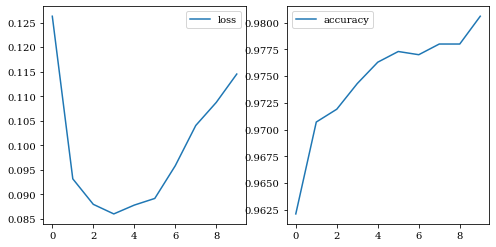

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax=fig.add_subplot(121)
ax.plot(serverhist1['accuracy'], label="loss")
ax.legend()
ax=fig.add_subplot(122)
ax.plot(serverhist1['loss'], label="accuracy")
ax.legend()
plt.savefig("Clustered Genetic FL", dpi=300)
plt.show()

In [ ]:
losses

[0.4576,
 0.1025,
 0.1085,
 0.7036,
 0.5865,
 0.9548,
 0.1051,
 0.1047,
 0.3829,
 0.1047,
 0.1098,
 1.0243,
 0.7242,
 0.7467,
 0.5935,
 0.1069,
 0.1042,
 0.1019,
 0.0964,
 0.0953,
 0.8523,
 0.1245,
 0.9579,
 0.7083,
 0.7291,
 0.0988,
 0.4813,
 0.7655,
 0.2837,
 0.1161]

In [ ]:
server_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.1145 - accuracy: 0.9806


[0.11451054364442825, 0.9805999994277954]

# Generic FL

In [ ]:
client_models = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

server_model_norm = create_server_model()
server_model_norm.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
serverhist={
    "loss":[],
    "accuracy":[]
}

for i in range(NUM_ROUNDS):
  print("-----"+str(i)+"---------")
  losses = []
  lr_init = []
  data= []
  for j in range(NUM_CLIENTS):
    data.append(train_client(j, server_model_norm, 0.0001))

    client_models[j] = data[j][0]
    losses.append(data[j][2])
    lr_init.append(data[j][1])

  # Aggregating model
  sum=[i*0 for i in client_models[0].get_weights()]
  for i in range(NUM_CLIENTS):
    sum = [i+j for i, j in zip(client_models[i].get_weights(), sum)]
  server_model_norm.set_weights([i/NUM_CLIENTS for i in sum])
  h=server_model_norm.evaluate(X_test,y_test)
  serverhist['loss'].append(h[1])
  serverhist['accuracy'].append(h[0])



-----0---------
Epoch 1/2
150/150 [==============================] - 3s 15ms/step - loss: 1.2784 - accuracy: 0.7355 - val_loss: 0.6644 - val_accuracy: 0.8459
Epoch 2/2
150/150 [==============================] - 2s 11ms/step - loss: 0.5199 - accuracy: 0.8713 - val_loss: 0.4327 - val_accuracy: 0.8860
Epoch 1/2
99/99 [==============================] - 2s 15ms/step - loss: 1.5492 - accuracy: 0.6710 - val_loss: 0.8974 - val_accuracy: 0.8350
Epoch 2/2
99/99 [==============================] - 1s 14ms/step - loss: 0.6766 - accuracy: 0.8543 - val_loss: 0.5298 - val_accuracy: 0.8770
Epoch 1/2
112/112 [==============================] - 2s 18ms/step - loss: 1.4498 - accuracy: 0.6814 - val_loss: 0.8364 - val_accuracy: 0.8311
Epoch 2/2
112/112 [==============================] - 2s 16ms/step - loss: 0.6127 - accuracy: 0.8620 - val_loss: 0.5023 - val_accuracy: 0.8775
Epoch 1/2
96/96 [==============================] - 2s 20ms/step - loss: 1.5654 - accuracy: 0.6535 - val_loss: 0.9187 - val_accuracy: 0.8

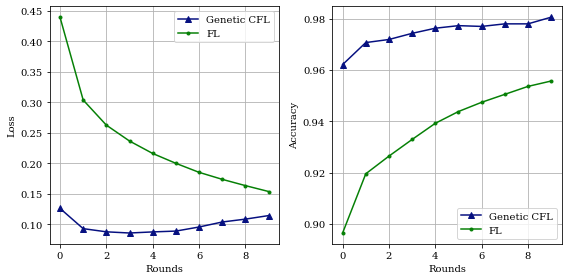

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax=fig.add_subplot(121)
ax.plot(serverhist1['accuracy'], label="Genetic CFL", color="#061080", marker = "^")
ax.plot(serverhist['accuracy'], label="FL", color="#068006", marker=".")
ax.legend()
ax.grid(True)
ax.set_xlabel("Rounds")
ax.set_ylabel("Loss")
ax=fig.add_subplot(122)
ax.plot(serverhist1['loss'], label="Genetic CFL", color="#061080", marker="^")
ax.plot(serverhist['loss'], label="FL", color="#068006", marker=".")
ax.legend()
ax.grid(True)
ax.set_xlabel("Rounds")
ax.set_ylabel("Accuracy")
plt.tight_layout()
plt.savefig("Generic FL.pdf", dpi=300)
plt.show()

In [ ]:
from google.colab import files
files.download("Generic FL.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Normal Training

In [ ]:
server_model_norm = create_server_model()
num=0
server_model_norm.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
n_hist=server_model_norm.fit(X_train[6000*num:6000*(num+1)], y_train[6000*num:6000*(num+1)], epochs=10, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax=fig.add_subplot(121)
ax.plot(n_hist.history['accuracy'], label="accuracy")
ax.plot(n_hist.history['val_accuracy'], label="val accuracy")
ax.legend()
ax=fig.add_subplot(122)
ax.plot(n_hist.history['loss'], label="loss")
ax.plot(n_hist.history['val_loss'], label="val loss")
ax.legend()
plt.savefig("Generic", dpi=300)
plt.show()